In [18]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import pandas as pd
from glob import glob
from fastcore.xtras import load_pickle, save_pickle
from pathlib import Path

from sklearn.model_selection import train_test_split
from pycm import ConfusionMatrix
import optuna

import numpy as np
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
import time
import os
import shap

from plotutils.plotutils import *

plt.style.use("plotutils/kevin.mplstyle")


import matplotlib.pyplot as plt

from pymatgen.io.ase import AseAtomsAdaptor

from pymatgen.core import Structure


from visualization import create_atoms_with_color_arrays, show_atoms

In [20]:
# Classifier that performs optuna hyperopt in the fit call
class XGBoostOptunaClassifier(xgb.XGBClassifier):
    def __init__(self, n_trials=100, **kwargs):
        super().__init__(**kwargs)
        self.n_trials = n_trials

    def fit(self, X, y, seed, *args, **kwargs):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        def objective(trial):
            params = {
                "learning_rate": trial.suggest_float(
                    "learning_rate", 1e-2, 0.25, log=True
                ),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
                "subsample": trial.suggest_float("subsample", 0.1, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
                "max_depth": trial.suggest_int("max_depth", 1, 9),
                "n_estimators": trial.suggest_categorical(
                    "n_estimators", [7000, 15000, 20000]
                ),
            }

            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train,
                y_train,
                early_stopping_rounds=10,
                eval_set=[(X_val, y_val)],
                verbose=False,
            )

            y_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            return 1.0 - accuracy

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=self.n_trials)

        self.best_params_ = study.best_params
        super().set_params(**self.best_params_)

        return super().fit(X, y, *args, **kwargs)

In [21]:
all_data = pd.read_pickle("../data/all_data.pkl")
feature_names = load_pickle("../data/feature_names.pkl")
feature_names = [f for f in all_data.columns if "phimage" in f]

In [22]:
train, test = train_test_split(
    all_data, train_size=0.8, stratify=all_data["below_benchmark"]
)

In [23]:
model = XGBoostOptunaClassifier(n_trials=100)
model.fit(train[feature_names].values, train["below_benchmark"].astype(int), seed=42)

[I 2023-06-13 14:04:56,060] A new study created in memory with name: no-name-a0e9e14e-aa06-49dc-b889-5447dca92fdf
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2023-06-13 14:04:57,518] Trial 0 finished with value: 0.3153153153153153 and parameters: {'learning_rate': 0.010815845580530828, 'reg_lambda': 1.0420834052464856e-07, 'reg_alpha': 7.42970510156966e-07, 'subsample': 0.5681337508567107, 'colsample_bytree': 0.11723391206055228, 'max_depth': 6, 'n_estimators': 7000}. Best is trial 0 with value: 0.3153153153153153.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2023-06-13 14:04:57,839] Trial 1 finished with value: 0.3153153153153153 and parameters: {'learning_rate': 0.1774250264081654, 'reg_lambda': 1.105585775682191, 'reg_alpha': 0.144295529795

[14:07:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_trials" } are not used.



XGBoostOptunaClassifier(base_score=None, booster=None, callbacks=None,
                        colsample_bylevel=None, colsample_bynode=None,
                        colsample_bytree=0.692417348963205,
                        early_stopping_rounds=None, enable_categorical=False,
                        eval_metric=None, feature_types=None, gamma=None,
                        gpu_id=None, grow_policy=None, importance_type=None,
                        interaction_constraints=None,
                        learning_rate=0.032809707485356186, max_bin=None,
                        max_cat_threshold=None, max_cat_to_onehot=None,
                        max_delta_step=None, max_depth=5, max_leaves=None,
                        min_child_weight=None, missing=nan,
                        monotone_constraints=None, n_estimators=20000,
                        n_jobs=None, num_parallel_tree=None,
                        objective='binary:logistic', predictor=None, ...)

In [24]:
predictions = model.predict(test[feature_names])

In [25]:
cm = ConfusionMatrix(test["below_benchmark"].values.astype(int), predictions)

In [26]:
print(cm)

Predict  0        1        
Actual
0        42       19       

1        22       55       





Overall Statistics : 

95% CI                                                            (0.62665,0.77914)
ACC Macro                                                         0.7029
ARI                                                               0.15858
AUNP                                                              0.70141
AUNU                                                              0.70141
Bangdiwala B                                                      0.49875
Bennett S                                                         0.4058
CBA                                                               0.68527
CSI                                                               0.40115
Chi-Squared                                                       22.20696
Chi-Squared DF                                                    1
Conditional Entropy                                            

In [27]:
model = xgb.XGBClassifier(**model.best_params_)
model.fit(all_data[feature_names].values, all_data["below_benchmark"].astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.692417348963205, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.032809707485356186,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [28]:
save_pickle("../models/20230613-model-cac-cement_all.pkl", model)

## Now, get the SHAP feature importance


In [29]:
explainer = shap.TreeExplainer(model)

In [47]:
shap_values = explainer.shap_values(
    all_data[all_data["below_benchmark"]].sort_values(by="nCAC", ascending=True)[
        feature_names
    ]
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


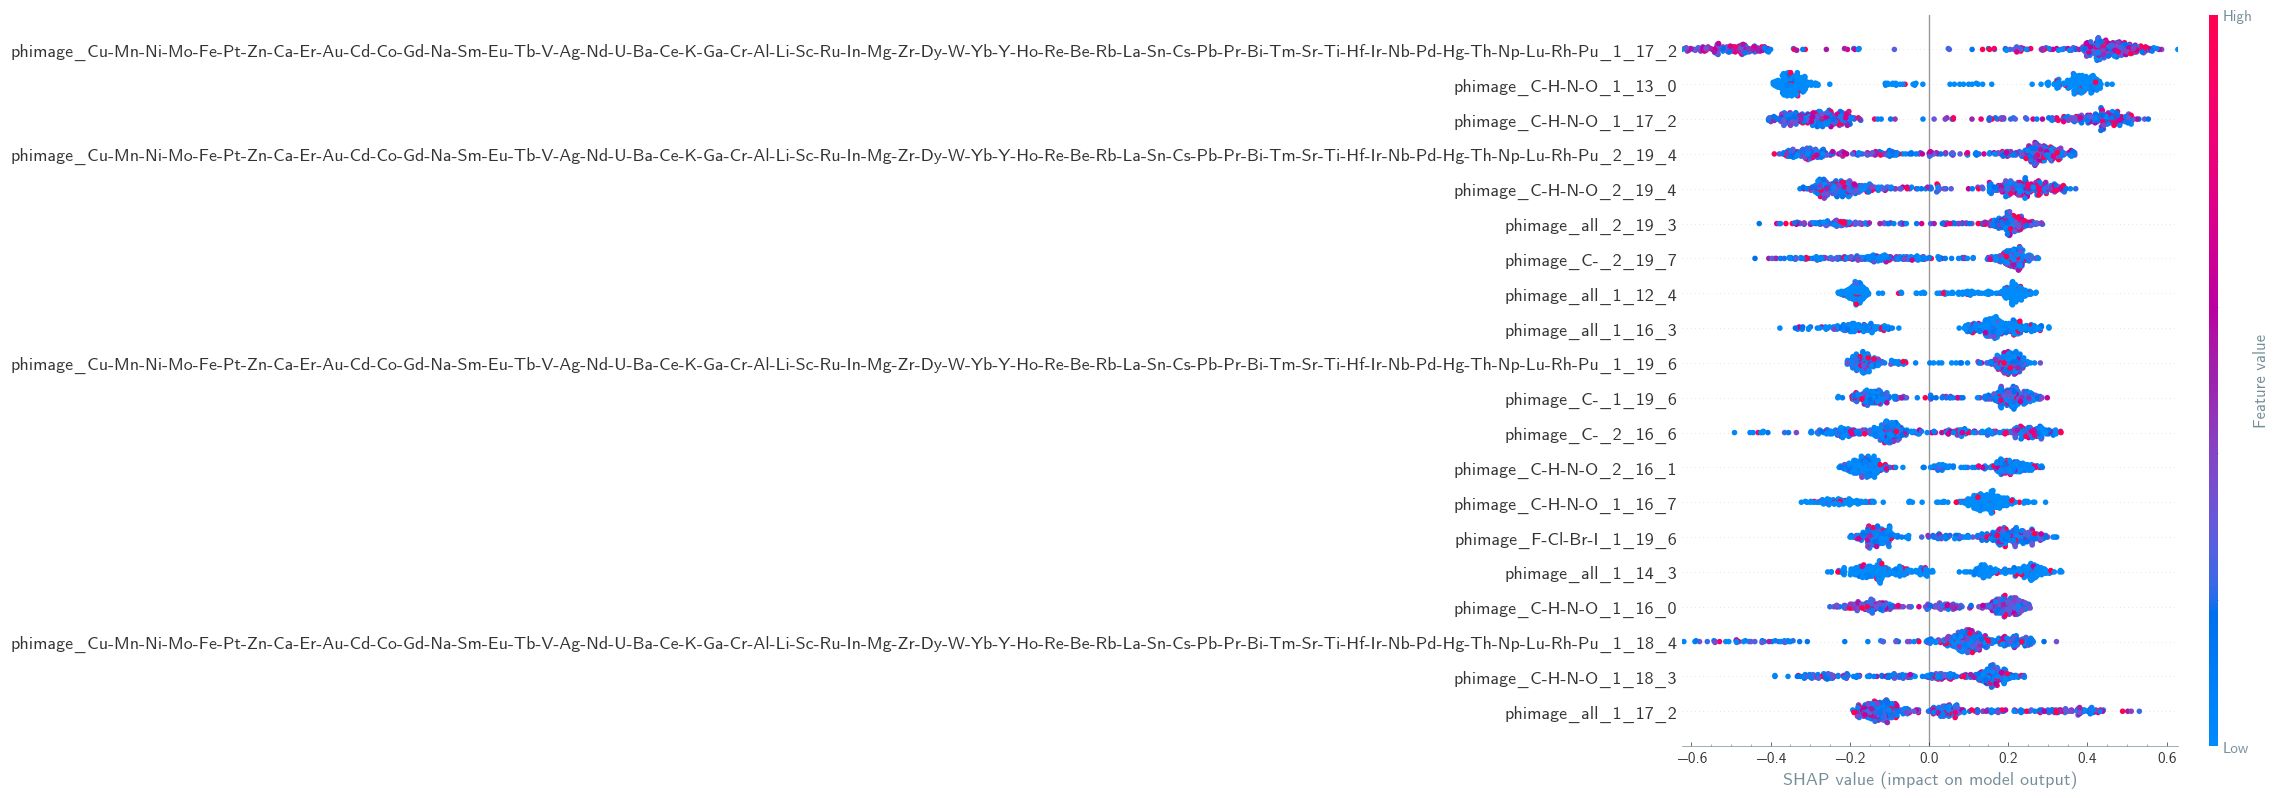

In [48]:
shap.summary_plot(
    shap_values,
    features=all_data[all_data["below_benchmark"]].sort_values(
        by="below_benchmark", ascending=True
    )[feature_names],
    feature_names=feature_names,
)

In [49]:
dim_0_indices = []
dim_1_indices = []
dim_2_indices = []

c_indices = []
halogen_indices = []
metal_indices = []
all_indices = []
chno_indices = []

for i, name in enumerate(feature_names):
    dim = int(name.split("_")[-3])
    if dim == 0:
        dim_0_indices.append(i)
    elif dim == 1:
        dim_1_indices.append(i)
    elif dim == 2:
        dim_2_indices.append(i)

    elem = name.split("_")[1]

    if elem == "C-":
        c_indices.append(i)
    elif "Cu" in elem:
        metal_indices.append(i)
    elif "F" in elem:
        halogen_indices.append(i)
    elif "all" in elem:
        all_indices.append(i)
    else:
        chno_indices.append(i)

In [50]:
dim_0_importance = model.feature_importances_[np.array(dim_0_indices)].sum()
dim_1_importance = model.feature_importances_[np.array(dim_1_indices)].sum()
dim_2_importance = model.feature_importances_[np.array(dim_2_indices)].sum()

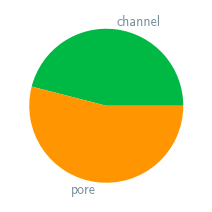

In [51]:
plt.pie(
    [dim_0_importance, dim_1_importance, dim_2_importance],
    labels=["", "channel", "pore"],
)
plt.savefig("../visuals/ph_dim_importance_nCAC.pdf", bbox_inches="tight")
# plt.savefig('../visuals/ph_dim_importance_nCAC.png', dpi=400, bbox_inches='tight')

In [52]:
c_importance = model.feature_importances_[np.array(c_indices)].sum()
halogen_importance = model.feature_importances_[np.array(halogen_indices)].sum()
metal_importance = model.feature_importances_[np.array(metal_indices)].sum()
all_importance = model.feature_importances_[np.array(all_indices)].sum()
chno_importance = model.feature_importances_[np.array(chno_indices)].sum()

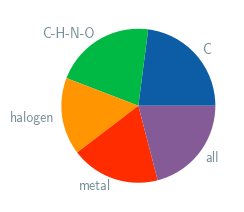

In [53]:
plt.pie(
    [
        c_importance,
        chno_importance,
        halogen_importance,
        metal_importance,
        all_importance,
    ],
    labels=["C", "C-H-N-O", "halogen", "metal", "all"],
)
# plt.savefig('ph_chem_importance.pdf', bbox_inches='tight')
plt.savefig("../visuals/ph_chem_importance.pdf", bbox_inches="tight")

### Now, let's look on a case-by-case basis what the most important features are


In [54]:
from mofdscribe.featurizers.topology.ph_image import PHImage
from ase.io import read, write

In [55]:
featurizer = PHImage(
    atom_types=(
        "C-H-N-O",
        "C-",
        "F-Cl-Br-I",
        "Cu-Mn-Ni-Mo-Fe-Pt-Zn-Ca-Er-Au-Cd-Co-Gd-Na-Sm-Eu-Tb-V"
        "-Ag-Nd-U-Ba-Ce-K-Ga-Cr-Al-Li-Sc-Ru-In-Mg-Zr-Dy-W-Yb-Y-"
        "Ho-Re-Be-Rb-La-Sn-Cs-Pb-Pr-Bi-Tm-Sr-Ti-Hf-Ir-Nb-Pd-Hg-"
        "Th-Np-Lu-Rh-Pu",
    ),
    spread=0.15,
    min_size=100,
    max_fit_tolerance=0.2,
)

featurizer.max_b = [0.0, 11.85585823059082, 11.856735992431641, 0.0]
featurizer.max_p = [8.401015663146973, 8.07491397857666, 4.6178689956665036, 0.0]

In [56]:
names = all_data[all_data['below_benchmark']].sort_values(by='nCAC', ascending=True).iloc[:10]['MOF_x'].values

In [59]:
for name in names:
    write(f'../visuals/top_nCAC_structures/{name}.png', read(f'../data/CIF-Files/{name}.cif'))

In [60]:
def create_subset_structure(s, indices):
    return Structure.from_sites([s for i, s in enumerate(s) if i in indices])

In [70]:
for i in range(10):
    for j in range(8):
        name = names[i]
        try:
            feature_index = j
            sorted_index_array = np.argsort(shap_values[i,:])[::-1]
            sorted_feature_names = np.array(feature_names)[sorted_index_array]
            sorted_feature_names[feature_index]
            s = Structure.from_file(f'../data/CIF-Files//{name}.cif')
            mol= featurizer.find_relevant_substructure(s, sorted_feature_names[feature_index])
            show_atoms(create_atoms_with_color_arrays(s, mol.original_structure_indices), f'../visuals/top_nCAC_fragments/{name}_{feature_index}_{sorted_feature_names[feature_index]}.pdf',)
            subset_structure = create_subset_structure(s, mol.original_structure_indices)
            subset_structure.to(f'../visuals/top_nCAC_fragments/{name}_{feature_index}_{sorted_feature_names[feature_index]}.cif')
        except Exception as e:
            print(name, feature_index,  sorted_feature_names[feature_index], e)

HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO


Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.


HELLOO
HELLOO
HELLOO
HELLOO
RSM0851 4 phimage_F-Cl-Br-I_1_18_4 'NoneType' object is not iterable
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
RSM1064 4 phimage_F-Cl-Br-I_1_19_6 'NoneType' object is not iterable
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
RSM1585 3 phimage_F-Cl-Br-I_1_19_6 'NoneType' object is not iterable
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
RSM1847 1 phimage_F-Cl-Br-I_2_19_6 'NoneType' object is not iterable
HELLOO
RSM1847 3 phimage_F-Cl-Br-I_1_19_6 'NoneType' object is not iterable
HELLOO
HELLOO
HELLOO
HELLOO
